In [1]:
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# import seaborn as sns
import pandas as pd

import sklearn
import scipy

import sys
import os
import pathlib
import itertools
import glob
import re
import datetime

from itertools import groupby
from operator import itemgetter

from sklearn.preprocessing import QuantileTransformer, StandardScaler

package_path = os.path.join(pathlib.Path.home(), "mkvchain")
sys.path.append(package_path)
from model import FeatureDependentMarkovChain

In [2]:
root = pathlib.Path.home()
pt1 = os.path.join(root, 'research', 'GADS_Processed', "trajectories_with_features")

def glob_re(pattern, strings):
    return list(filter(re.compile(pattern).match, strings))

filenames = glob_re(r"gen_\d+_type_100_dtgrp_\d+_rating_\d+_state_Texas_raw.csv", os.listdir(pt1))

In [ ]:
def consecutive_groups(iterable, ordering=lambda x: x):
    for k, g in groupby(enumerate(iterable), key=lambda x: x[0] - ordering(x[1])):
        yield map(itemgetter(1), g)

states_new = []
features_new = []
lengths_new = []
        
for f in filenames[:60]:
    # gen_id = int(re.findall(r"gen_(\d+)_.+", f)[0])

    data = pd.read_csv(os.path.join(pt1,f))
    data.set_index(pd.DatetimeIndex(data["x"]), inplace=True)
    data = data[~data.index.duplicated()]

    for c in ['y3', 'ERCOT', 'y4', 'Pcp', 'Tmax', 'Tmin', 'y6', 'y8', 'y7']:
        data = data[~data[c].isna()]

    if len(data) < 2:
        continue

    start = data.index[0]
    diffs = np.diff((data.index))
    hours = np.cumsum(diffs/np.timedelta64(1, 'h')).astype(int) - 1

    sequences = []
    for g in consecutive_groups(hours):
        sequences.append(list(g))

    for k in sequences:

        dts = pd.DatetimeIndex(start + np.array([datetime.timedelta(hours=int(h)) for h in k]))
        index = data.loc[dts[0]:dts[-1], :].index
        states = data.loc[index, "y2"].values.tolist()
        features = data.loc[index, ['y3', 'ERCOT', 'y4', 'Pcp', 'Tmax', 'Tmin', 'y6', 'y8', 'y7']].values
        l = len(k)

        states_new += [states]
        features_new += [features]

        
        lengths_new += [l]

states = np.concatenate(states_new).astype(int)
states -= 1
features = np.vstack(features_new)
lengths = np.array(lengths_new)

In [5]:
train_idx =  int(lengths.size * .8)
val_idx =  int(lengths.size * .9)

lengths_train = lengths[:train_idx]
lengths_val = lengths[train_idx:val_idx]
lengths_test = lengths[val_idx:]

states_train = states[:lengths_train.sum()]
states_val = states[lengths_train.sum():lengths_train.sum()+lengths_val.sum()]
states_test = states[lengths_train.sum()+lengths_val.sum():]

features_train = features[:lengths_train.sum()]
features_val = features[lengths_train.sum():lengths_train.sum()+lengths_val.sum()]
features_test = features[lengths_train.sum()+lengths_val.sum():]

In [6]:
features_train.shape, states_train.shape

((1269454, 9), (1269454,))

In [7]:

ss = StandardScaler()

features_train = ss.fit_transform(features_train)
features_val = ss.transform(features_val)
features_test = ss.transform(features_test)

In [8]:
n = 5
model1 = FeatureDependentMarkovChain(n, lam_frob=0.001, n_iter=1)
model1.fit(states_train, features_train*0, lengths_train, verbose=False)


# train1, val1, test1 = model1.score(states_train, features_train*0, lengths_train, average=False), \
#     model1.score(states_val, features_val*0, lengths_val, average=False), \
#     model1.score(states_test, features_test*0, lengths_test, average=False)
# model1.score(states_test, features_test*0, lengths_test, average=False)
# train1, val1, test1

predictions = model1.predict(features_val)
for i, j in itertools.product(range(4), range(4)):
    y = predictions[:, i, j]
    val = len(np.unique(y.round(decimals=3)))
    print(f"{i} -> {j} : {val}")

0 -> 0 : 1
0 -> 1 : 1
0 -> 2 : 1
0 -> 3 : 1
1 -> 0 : 1
1 -> 1 : 1
1 -> 2 : 1
1 -> 3 : 1
2 -> 0 : 1
2 -> 1 : 1
2 -> 2 : 1
2 -> 3 : 1
3 -> 0 : 1
3 -> 1 : 1
3 -> 2 : 1
3 -> 3 : 1


In [9]:
from copy import deepcopy
train2, val2, test2 = -np.inf, -np.inf, -np.inf
best_lam = None
model2 = None
for lam in np.logspace(-3,-1,10):
    model = FeatureDependentMarkovChain(n, lam_frob=lam,  n_iter=1)
    model.As = deepcopy(model1.As)
    model.bs = deepcopy(model1.bs)
    model.fit(states_train, features_train, lengths_train, verbose=False, warm_start=True)
    traini, vali= model.score(states_train, features_train, lengths_train, average=False), \
          model.score(states_val, features_val, lengths_val, average=False)
        #   model.score(states_test, features_test, lengths_test, average=False)
    if vali > val2:
        train2 = traini
        val2 = vali
        # test2 = testi
        best_lam = lam
        model2 = model
# train2, val2# test2

model = FeatureDependentMarkovChain(n, lam_frob=best_lam, n_iter=1)
model.As = deepcopy(model1.As)
model.bs = deepcopy(model1.bs)
model.fit(states_train, features_train, lengths_train, verbose=False, warm_start=True)

predictions2 = model.predict(features_test)
for i, j in itertools.product(range(4), range(4)):
    y = predictions2[:, i, j]
    val = len(np.unique(y.round(decimals=3)))
    print(f"{i} -> {j} : {val}")

0 -> 0 : 11
0 -> 1 : 9
0 -> 2 : 2
0 -> 3 : 2
1 -> 0 : 16
1 -> 1 : 21
1 -> 2 : 5
1 -> 3 : 3
2 -> 0 : 5
2 -> 1 : 24
2 -> 2 : 28
2 -> 3 : 2
3 -> 0 : 4
3 -> 1 : 6
3 -> 2 : 2
3 -> 3 : 8


In [11]:
best_lam

np.float64(0.001)

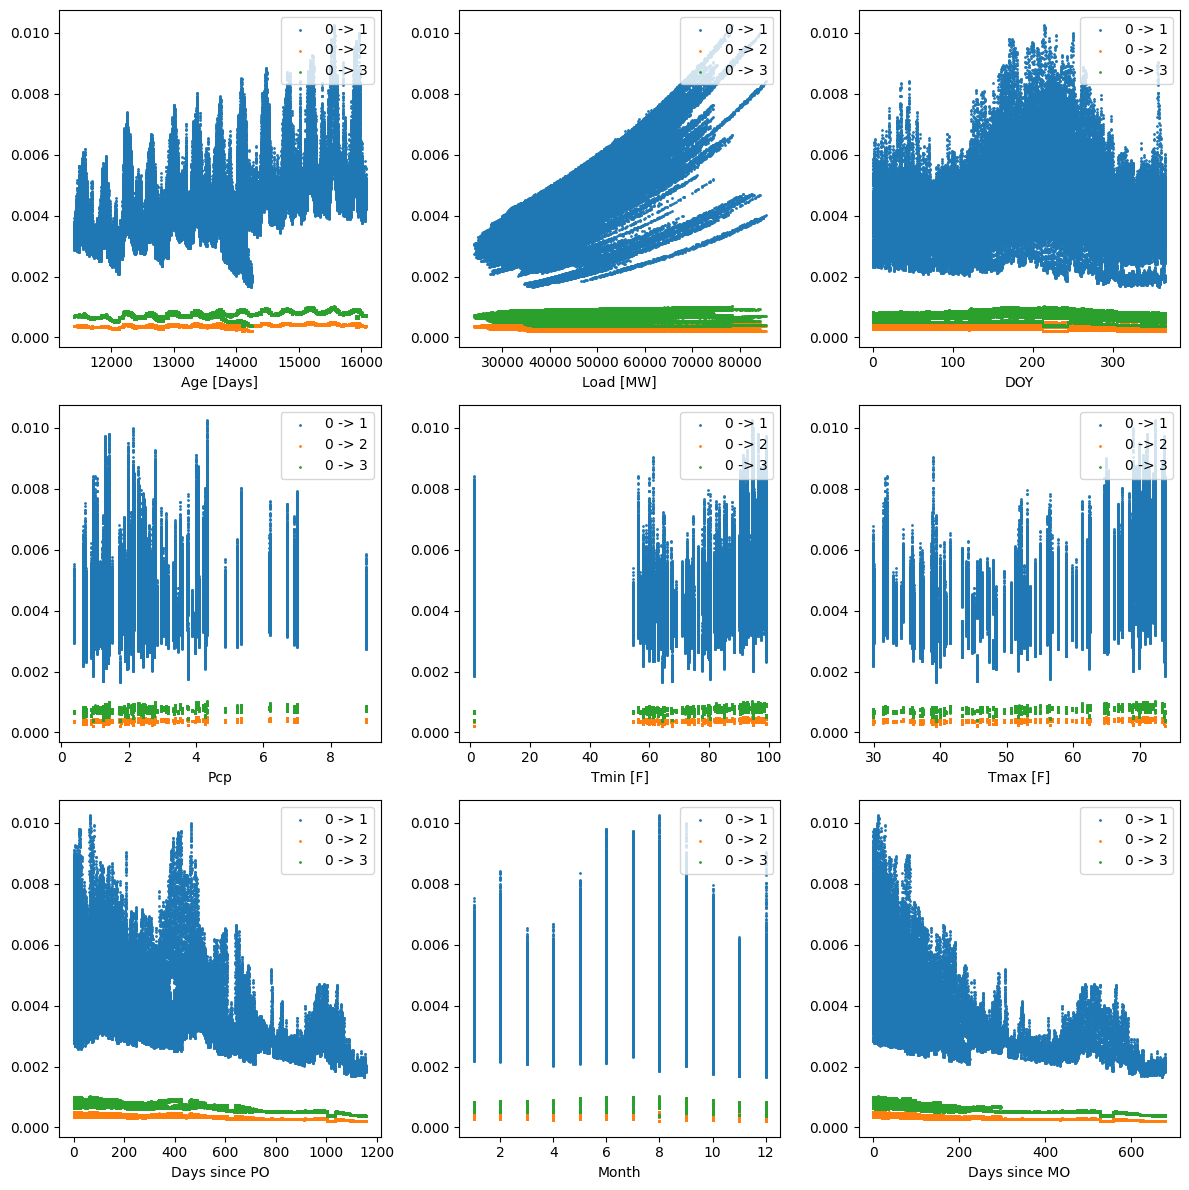

In [12]:
feature_names = ['Age [Days]', 'Load [MW]', 'DOY', 'Pcp', "Tmin [F]", "Tmax [F]", 'Days since PO', 'Month', 'Days since MO']
features_test2 = features[lengths_train.sum()+lengths_val.sum():]

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,12))

for i in range(9):

    if i//3 < 1:
        k = 0
        j = i
    elif i//3 < 2:
        k = 1
        j = np.mod(i, 3)
    else:
        k = 2
        j = np.mod(i, 3)

    f = features_test2[:, i]

    for m, n in itertools.product([0], range(1,4)):
    
        ax[k, j].scatter(f, predictions2[:, m, n], s=1, label=f"{m} -> {n}")
    
    ax[k, j].set_xlabel(feature_names[i])
    ax[k, j].legend(loc='upper right')
    # ax[i, j].set_yscale('log')

fig.tight_layout()

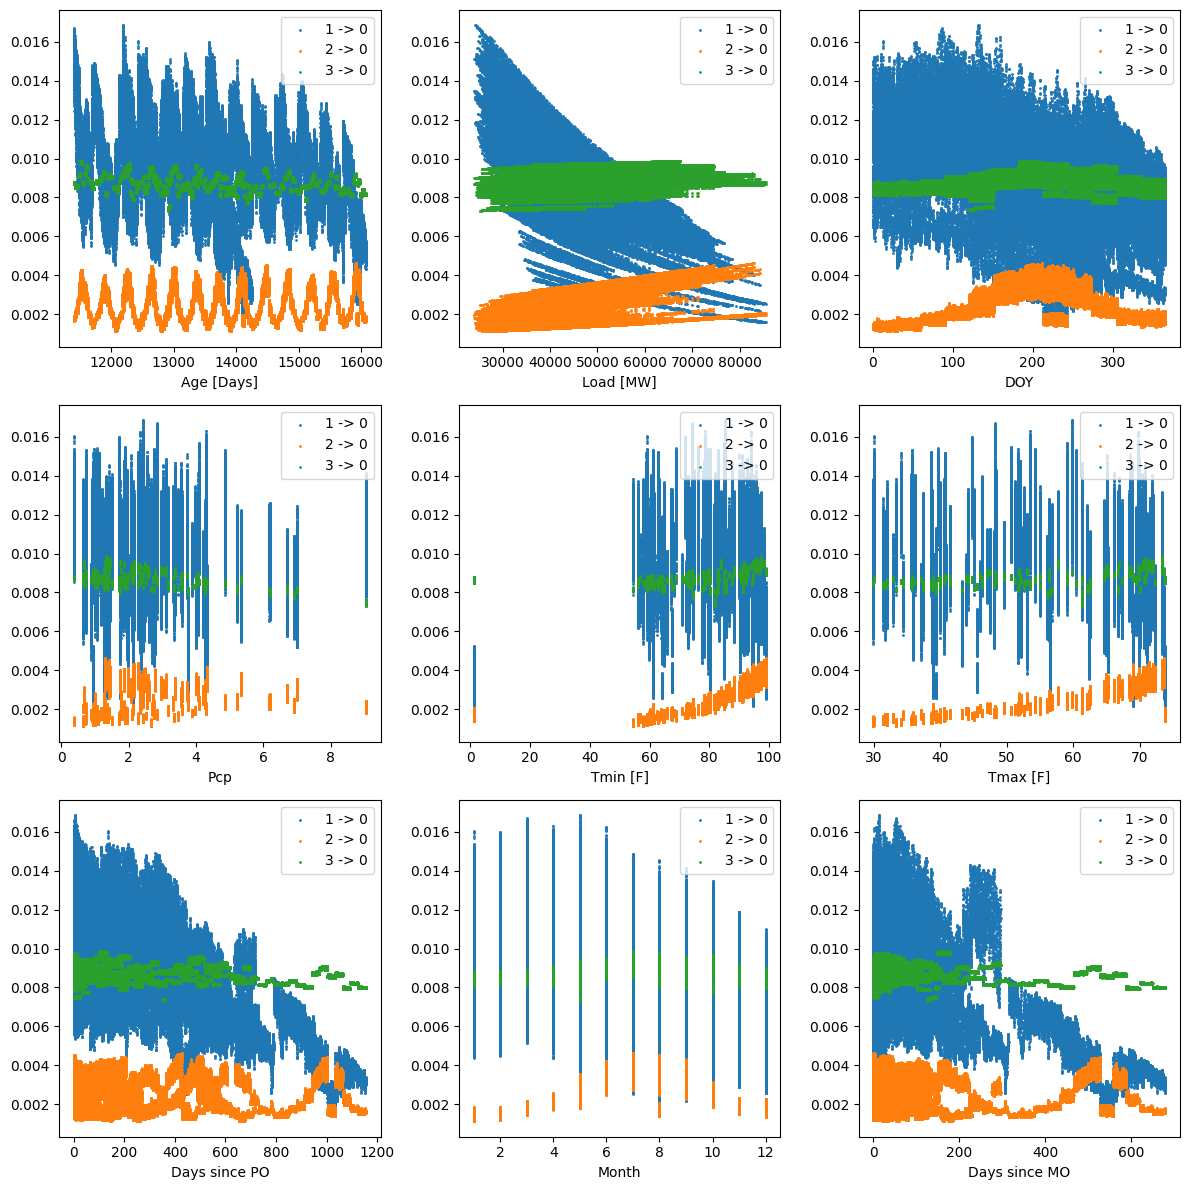

In [13]:
feature_names = ['Age [Days]', 'Load [MW]', 'DOY', 'Pcp', "Tmin [F]", "Tmax [F]", 'Days since PO', 'Month', 'Days since MO']
features_test2 = features[lengths_train.sum()+lengths_val.sum():]

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,12))

for i in range(9):

    if i//3 < 1:
        k = 0
        j = i
    elif i//3 < 2:
        k = 1
        j = np.mod(i, 3)
    else:
        k = 2
        j = np.mod(i, 3)

    f = features_test2[:, i]

    for m, n in itertools.product(range(1,4), [0] ):
    
        ax[k, j].scatter(f, predictions2[:, m, n], s=1, label=f"{m} -> {n}")
    
    ax[k, j].set_xlabel(feature_names[i])
    ax[k, j].legend(loc='upper right')
    # ax[i, j].set_yscale('log')

fig.tight_layout()

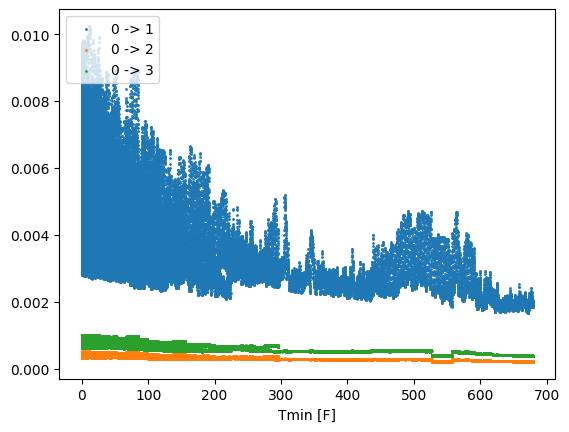

In [14]:
fig, ax = plt.subplots()

f = features_test2[:, 8]

for m, n in itertools.product([0], range(1,4)):
    
    ax.scatter(f, predictions2[:, m, n], s=1, label=f"{m} -> {n}")

ax.set_xlabel("Tmin [F]")
ax.legend(loc="upper left")

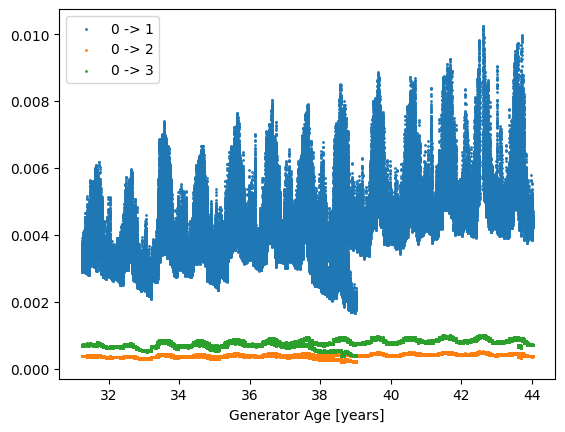

: 

In [ ]:
fig, ax = plt.subplots()

f = features_test2[:, 0]

for m, n in itertools.product([0], range(1,4)):
    
    ax.scatter(f/365, predictions2[:, m, n], s=1, label=f"{m} -> {n}")

ax.set_xlabel("Generator Age [years]")
ax.legend(loc="upper left")